In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gold_dataset=pd.read_csv("monthly_csv.csv")
gold_dataset1=gold_dataset

In [3]:
print(gold_dataset1[gold_dataset1["Price"]<=0])

Empty DataFrame
Columns: [Date, Price]
Index: []


In [4]:
gold_dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    847 non-null    object 
 1   Price   847 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.4+ KB


In [5]:
gold_dataset1.describe()

,Price
count,847.000000
mean,416.556906
std,453.665313
min,34.490000
25%,35.190000
50%,319.622000
75%,447.029000
max,1840.807000


In [6]:
gold_dataset1.isnull().sum()

Date     0
Price    0
dtype: int64

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
from EDAcentral import EDA  #(userdefined class and functions for EDA)

In [9]:
eda=EDA(gold_dataset[["Price"]])
centraluni=eda.central()
centraluni

,Price
Mean,416.556906
Median,319.622
Mode,35.08
Q1:25,35.19
Q2:50,319.622
Q3:75,447.029
Q4:100,1840.807
IQR,411.839
1.5*IQR,617.7585
Lesser,-582.5685


In [10]:
Lesser=[]
Greater=[]
Lesser,Greater=eda.outlierscheck()

In [11]:
gold_dataseteda=eda.outliersreplace()
gold_dataseteda


,Price
0,34.7300
1,34.7300
2,34.7300
3,34.7300
4,34.7300
...,...
842,1064.7875
843,1064.7875
844,1064.7875
845,1064.7875


In [12]:
eda1=EDA(gold_dataseteda)

In [13]:
centraluni=eda1.central()
centraluni

,Price
Mean,371.381164
Median,319.622
Mode,1064.7875
Q1:25,35.19
Q2:50,319.622
Q3:75,447.029
Q4:100,1064.7875
IQR,411.839
1.5*IQR,617.7585
Lesser,-582.5685


In [14]:
Lesser,Greater=eda1.outlierscheck()
Lesser
Greater

[]

In [15]:
from Frequency import Freq
Freqobj=Freq(gold_dataseteda)

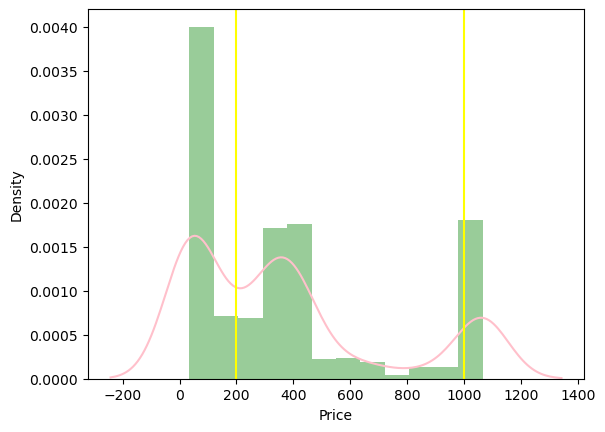

The price between (200,1000),(0.6472027633159148,64.72027633159148),0.8335301062573789)


In [16]:
Freqobj.calc_pdf()

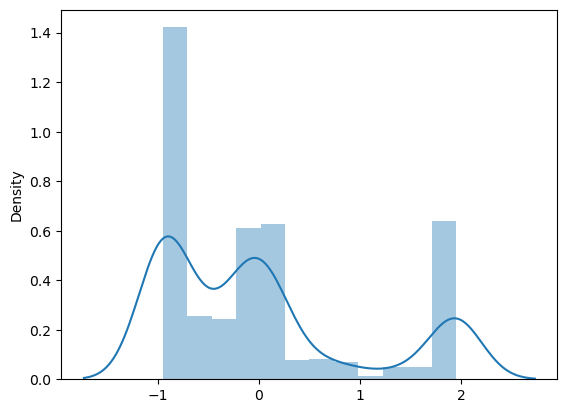

,Z_score
0,-0.947578
1,-0.947578
2,-0.947578
3,-0.947578
4,-0.947578
...,...
842,1.951743
843,1.951743
844,1.951743
845,1.951743


In [17]:
Freqobj.normal()

-0.947578 → These values are below the mean by nearly 1 standard deviation.

1.951743 → These values are above the mean by nearly 2 standard deviations.

If these values are repeated exactly, it likely means your original data had many repeated values (e.g., same price or frequency), and when Z-scored, they all got mapped to the same Z-value.

If you're working with frequency-based or binned data:

All values in one bin (e.g., prices between $100 and $200) may have had the same frequency.

Standardizing those identical frequencies will result in identical Z-scores.

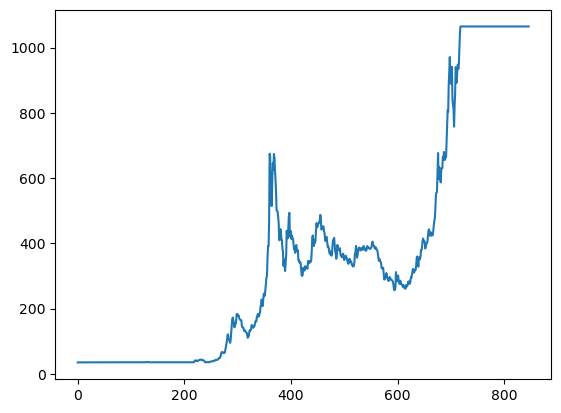

In [18]:
plt.plot(gold_dataseteda["Price"])

In [19]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(gold_dataseteda["Price"])
result

(0.030437455130185125,
 0.9609780171044042,
 20,
 826,
 {'1%': -3.4382915719823934,
  '5%': -2.8650454292904577,
  '10%': -2.568636586835826},
 6943.661282365852)

In [20]:
Statistic=result[0]
p_value=result[1]
critical_values=result[4]
print("p-value<=0.05-->Accept Alternate Hypothesis")
print("p-value>0.05-->Accept Null Hypothesis")
if Statistic < critical_values["1%"] or Statistic < critical_values["5%"] or Statistic < critical_values["10%"] or p_value < 0.05:
    print(" Rejecting null and accepting alternate the data are stationary")
else:
    print(" accepting null and rejecting alternate the data are non-stationary")

p-value<=0.05-->Accept Alternate Hypothesis
p-value>0.05-->Accept Null Hypothesis
 accepting null and rejecting alternate the data are non-stationary


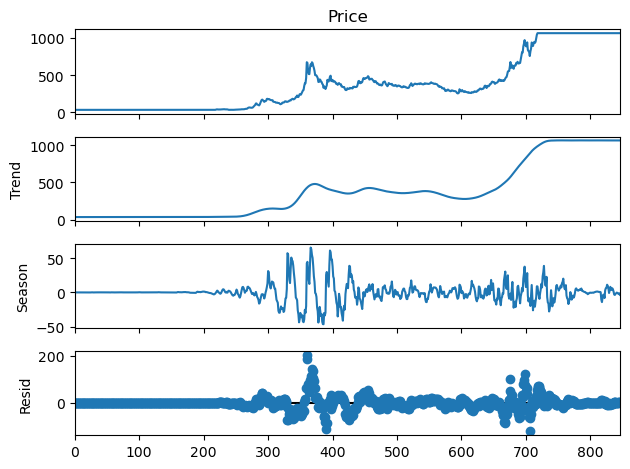

In [21]:
from statsmodels.tsa.seasonal import STL
decomposition=STL(gold_dataseteda["Price"],period=30).fit()
decomposition.plot()
plt.show()

The non-stationarity is due to both season and trend

In [22]:
gold_dataseteda1=gold_dataseteda.diff().dropna()

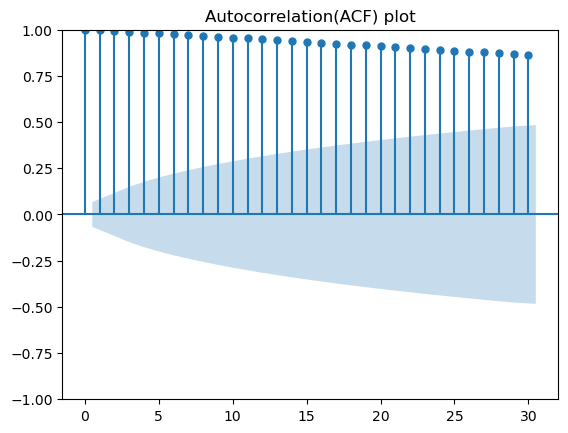

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(gold_dataseteda["Price"],lags=30)
plt.title("Autocorrelation(ACF) plot")
plt.show()

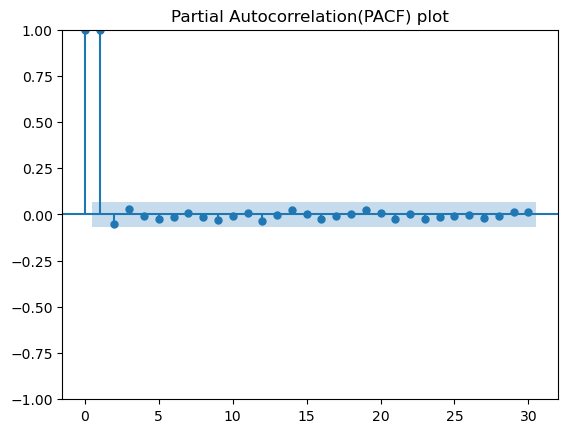

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(gold_dataseteda["Price"],lags=30)
plt.title("Partial Autocorrelation(PACF) plot")
plt.show()

In [25]:
stan=np.log1p(gold_dataseteda["Price"]) # log(1 + x)

In [26]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()
gold_dataseteda["Price"]=gold_dataseteda["Price"]
stan = mms.fit_transform(gold_dataseteda[["Price"]])
stan = pd.Series(stan.flatten(), index=gold_dataseteda.index)
print("Len",stan.shape)

Len (847,)


In [27]:
data_size=round(len(stan)*0.75)
train=stan[:data_size]
test=stan[data_size:]

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
sarimodel=SARIMAX(train,order=(1,1,1),sesonal_order=(1,1,1,12))
sarifit=sarimodel.fit(disp=False)

In [29]:
forecast=sarifit.predict(start=test.index[0],end=test.index[-1])
mse=mean_squared_error(test,forecast,squared=False)
#to replace zero values with some minute values
safe_test = test.copy()
safe_test[safe_test == 0] = 1e-10 
mape=mean_absolute_percentage_error(safe_test,forecast)
print("mse={},mape={}".format(mse,mape))
print("************")         

mse=0.6035845588998563,mape=0.6062989112093804
************


In [30]:
pred=np.expm1(forecast)
test_actual=np.expm1(test)
mse=mean_squared_error(test,pred,squared=False)
#to replace zero values with some minute values
safe_test = test.copy()
safe_test[safe_test == 0] = 1e-10 
mape=mean_absolute_percentage_error(safe_test,pred)
print("mse={},mape={}".format(mse,mape))     


mse=0.5652646231373355,mape=0.5504796057104963


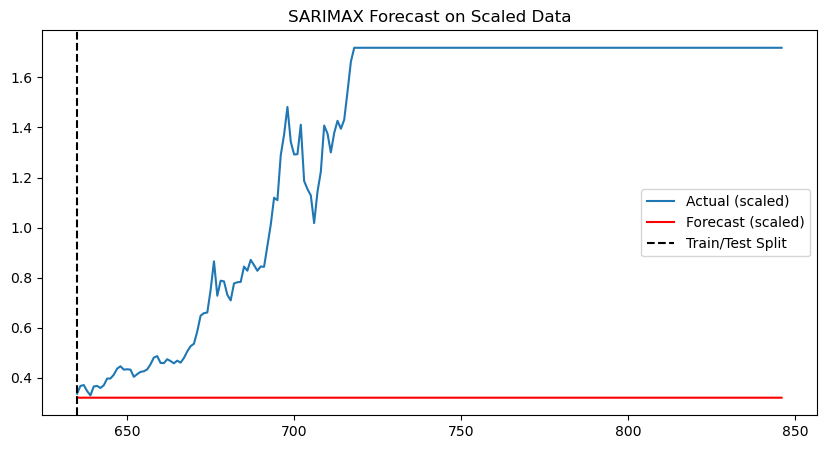

In [32]:
#Plot
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual (scaled)')
plt.plot(pred, label='Forecast (scaled)', color='red')
plt.axvline(x=test_actual.index[0], color='black', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('SARIMAX Forecast Actual Data')
plt.show()